In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

%matplotlib inline
plt.style.use('ggplot')

def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names,comment=';')
    return data
# normalisation of dataset using Z-score technique
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex= True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)

dataset = read_data('WISDM_ar_v1.1_raw.txt')
dataset.dropna(axis=0, how='any', inplace= True)
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])
# processing data to input into the CNN model
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)
        
def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["timestamp"], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset["timestamp"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)
# organising into training and testing sets
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

input_height = 1
input_width = 90
num_labels = 6
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 1000

learning_rate = 0.0001
training_epochs = 20

total_batchs = train_x.shape[0] // batch_size

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')
# convolution
def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))

# maxpooling
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1],strides=[1, 1, stride_size, 1], padding='VALID')
X_input = tf.placeholder(tf.float32, shape=[None,input_width * num_channels], name="input")
X = tf.reshape(X_input,[-1,1,90,3])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,21,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver=tf.train.Saver()

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        validation = np.empty(shape=[1],dtype=float)
        for b in range(total_batchs):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            val_x=test_x[offset:(offset+batch_size),:,:,:]
            val_y=test_y[offset:(offset+batch_size),:]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            _, v = session.run([optimizer,loss],feed_dict={X: val_x, Y:val_y})

            cost_history = np.append(cost_history,c)
            validation =np.append(validation,v)
        print ("Epoch: ",epoch," Training Loss: ",np.mean(cost_history)," Training Accuracy: ",session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        predictions=session.run(y_,feed_dict={X:test_x, Y:test_y})
        print ("Epoch: ",epoch,"Validation loss: ",np.mean(validation),"Validation Accuracy: ", session.run(accuracy,feed_dict={X:test_x,Y:test_y}))
    print( "Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y:test_y}))
    tf.train.write_graph(session.graph_def, '.','C:/Users/HP/har.pbtxt')
    saver.save(session,save_path = "C:/Users/HP/har.ckpt")

Epoch:  0  Training Loss:  5.639179788389867  Training Accuracy:  0.7895474
Epoch:  0 Validation loss:  3.7956070363912566 Validation Accuracy:  0.79763055
Epoch:  1  Training Loss:  7.790978220346283  Training Accuracy:  0.83405274
Epoch:  1 Validation loss:  2.145374740448502 Validation Accuracy:  0.8353768
Epoch:  2  Training Loss:  5.5981304160518475  Training Accuracy:  0.85446805
Epoch:  2 Validation loss:  5.59144872630873 Validation Accuracy:  0.8561785
Epoch:  3  Training Loss:  8.693356599908256  Training Accuracy:  0.87138355
Epoch:  3 Validation loss:  3.751044848559078 Validation Accuracy:  0.872572
Epoch:  4  Training Loss:  6.561826065253585  Training Accuracy:  0.8839827
Epoch:  4 Validation loss:  7.05050443754991 Validation Accuracy:  0.88235295
Epoch:  5  Training Loss:  9.610020857904637  Training Accuracy:  0.8930238
Epoch:  5 Validation loss:  5.085240681857105 Validation Accuracy:  0.8935115
Epoch:  6  Training Loss:  7.463362204728669  Training Accuracy:  0.8946

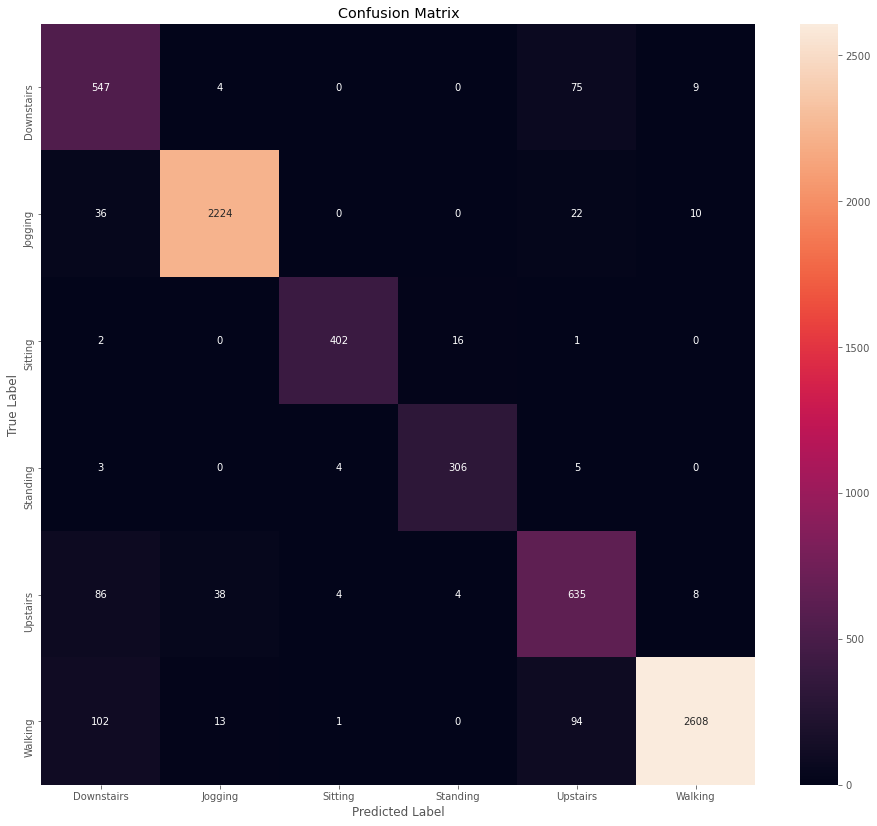

In [10]:
import seaborn as sns
from sklearn import metrics
LABELS=['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
max_test=np.argmax(test_y,axis=1)
max_predictions=np.argmax(predictions,axis=1)
confusion_matrix=metrics.confusion_matrix(max_test,max_predictions)
plt.figure(figsize=(16,14))
sns.heatmap(confusion_matrix,xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt="d");
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show();